# Check actin intensity distribution

Load the QC-normalized single-cell profiles and compare the distribution of actin intensity between cells labeled `Healthy` and `Failing`.

In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (8, 5), "figure.dpi": 100})
sns.set_style("whitegrid")

In [2]:
# Load QC-normalized single-cell parquet files for both plates
data_dir = (
    Path("..") / "3.preprocessing_profiles" / "data" / "single_cell_profiles"
)  # notebook is in 4.EDA
sc_paths = sorted(data_dir.glob("*_sc_normalized.parquet"))

if not sc_paths:
    raise FileNotFoundError(f"No normalized parquet files found in {data_dir}")

print("Found files:")
for p in sc_paths:
    print("  -", p)

# Read and concatenate all normalized plates
dfs = [pd.read_parquet(p) for p in sc_paths]
df = pd.concat(dfs, ignore_index=True)
print(f"Loaded rows: {len(df)} (from {len(dfs)} file(s))")

Found files:
  - ../3.preprocessing_profiles/data/single_cell_profiles/CARD-CelIns-CX7_251023130003_sc_normalized.parquet
  - ../3.preprocessing_profiles/data/single_cell_profiles/CARD-CelIns-CX7_251110170001_sc_normalized.parquet
Loaded rows: 19701 (from 2 file(s))


Plot saved to: figures/actin_intensity_healthy_vs_failing_by_plate.png


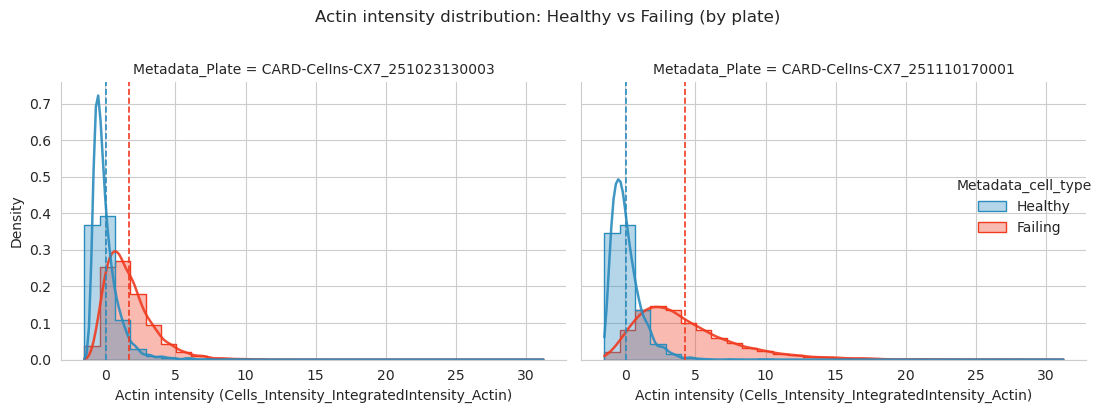


Summary statistics (by plate and cell type):
                                                 count      mean    median  \
Metadata_Plate               Metadata_cell_type                              
CARD-CelIns-CX7_251023130003 Failing              6789  1.673695  1.326244   
                             Healthy              4060  0.029913 -0.258839   
CARD-CelIns-CX7_251110170001 Failing              5607  4.266041  3.436601   
                             Healthy              3245  0.085917 -0.171328   

                                                      std  
Metadata_Plate               Metadata_cell_type            
CARD-CelIns-CX7_251023130003 Failing             1.685446  
                             Healthy             0.975580  
CARD-CelIns-CX7_251110170001 Failing             3.627589  
                             Healthy             1.066426  


In [3]:
# Preferred columns
actin_col = "Cells_Intensity_IntegratedIntensity_Actin"
metadata_col = "Metadata_cell_type"
plate_col = "Metadata_Plate"

# Locate actin column if preferred name not present
if actin_col not in df.columns:
    candidates = [
        c
        for c in df.columns
        if "actin" in c.lower()
        and ("intensity" in c.lower() or "integrated" in c.lower())
    ]
    if candidates:
        actin_col = candidates[0]
        print("Using actin column:", actin_col)
    else:
        raise ValueError(
            "No actin-related column found. Inspect dataframe columns to locate one."
        )

# Locate metadata column if preferred name not present
if metadata_col not in df.columns:
    candidates = [c for c in df.columns if "cell" in c.lower() and "type" in c.lower()]
    if candidates:
        metadata_col = candidates[0]
        print("Using metadata cell-type column:", metadata_col)
    else:
        raise ValueError(
            "No metadata cell-type column found. Inspect dataframe columns to locate one."
        )

if plate_col not in df.columns:
    raise ValueError(f"No plate column '{plate_col}' found in the dataframe.")

# Prepare subset: only Healthy and Failing (case-insensitive)
df = df.copy()
df[metadata_col] = df[metadata_col].astype(str)
mask = df[metadata_col].str.lower().isin(["healthy", "failing"])
df_subset = df.loc[mask, [plate_col, metadata_col, actin_col]].dropna()
if df_subset.empty:
    raise ValueError(
        "No rows found for Healthy or Failing labels. Check the metadata labels in the dataframe."
    )

# Ensure actin numeric
df_subset[actin_col] = pd.to_numeric(df_subset[actin_col], errors="coerce")
df_subset = df_subset.dropna(subset=[actin_col])

# Plot with filled KDE + histogram
palette = {"Healthy": "#2b8cbe", "Failing": "#f03b20"}

g = sns.displot(
    data=df_subset,
    x=actin_col,
    hue=metadata_col,
    col=plate_col,
    kind="hist",
    kde=True,
    element="step",
    stat="density",
    common_norm=False,
    bins=30,
    fill=True,
    palette=palette,
    alpha=0.35,
    height=4,
    aspect=1.2,
    legend=True,
)

# Adjust KDE overlay styling for clarity
for ax in g.axes.flatten():
    lines = ax.get_lines()
    for line in lines:
        line.set_linewidth(1.8)
        line.set_alpha(0.9)

# Labels and title
g.set_axis_labels(f"Actin intensity ({actin_col})", "Density")
g.fig.suptitle("Actin intensity distribution: Healthy vs Failing (by plate)", y=1.02)

# Add dashed vertical mean lines per plate and cell type
means = df_subset.groupby([plate_col, metadata_col])[actin_col].mean().unstack()
for ax in g.axes.flatten():
    title = ax.get_title()
    plate = title.split(" = ", 1)[-1] if " = " in title else title
    if plate not in means.index:
        continue
    for cell_type in means.columns:
        x = means.loc[plate, cell_type]
        ax.axvline(x, color=palette.get(cell_type, "k"), linestyle="--", linewidth=1.2)

plt.tight_layout()

# Save plot
output_plot_dir = Path("figures")
output_plot_dir.mkdir(parents=True, exist_ok=True)
output_plot_path = output_plot_dir / "actin_intensity_healthy_vs_failing_by_plate.png"
g.fig.savefig(output_plot_path, bbox_inches="tight", dpi=150)
print("Plot saved to:", output_plot_path)

plt.show()

# Optional summary: per-plate, per-cell-type stats
summary = (
    df_subset.groupby([plate_col, df_subset[metadata_col].str.title()])[actin_col]
    .agg(["count", "mean", "median", "std"])
    .rename_axis([plate_col, metadata_col])
)
print("\nSummary statistics (by plate and cell type):")
print(summary)